In [1]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
from aeon.io.reader import Reader, Csv
from dotmap import DotMap
import aeon.io.api as api
import os

root_folder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/'
root_folder_photometry = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/Photometry/2024_08_23-14_54_36/2024_08_23-14_54_36/'

h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData("SessionSettings")
experiment_events_reader = utils.TimestampedCsvReader("ExperimentEvents", columns=["Event"])
framecount_reader = utils.TimestampedCsvReader("OnixAnalogFrameCount", columns=["Index"])
photometry_reader = utils.PhotometryReader("Fluorescence")
video_reader = utils.Video("VideoData1")

h1_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/HarpDataH1/'
h2_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/HarpDataH2/'

In [14]:
# read experiment metadata
session_settings = utils.load(session_data_reader, root_folder)

print(session_settings)

                                                                     metadata
1904-01-06 01:46:41.470240  {'motorSettings': {'nominalPulseInterval': 200...


In [20]:
# read harp streams, experiment events, video
flow_sensor = utils.load_harp(h1_reader.OpticalTrackingRead, h1_datafolder)
analog_input = utils.load_harp(h2_reader.AnalogInput, h2_datafolder)
experiment_events = utils.load(experiment_events_reader, root_folder)
video_data = utils.load(video_reader, root_folder)

                            AnalogInput
Time                                   
1904-01-06 01:46:41.468480           34
1904-01-06 01:46:41.468992           35
1904-01-06 01:46:41.469504           32
1904-01-06 01:46:41.469984           33
1904-01-06 01:46:41.470496           32
...                                 ...
1904-01-06 02:18:42.141984           32
1904-01-06 02:18:42.142496           33
1904-01-06 02:18:42.142976           34
1904-01-06 02:18:42.143488           34
1904-01-06 02:18:42.144000           34

[3841133 rows x 1 columns]


                                                 Event        Seconds
Time                                                                 
1904-01-06 01:46:48.540256         Sync signal started  438408.540256
1904-01-06 01:47:05.810240  LinearNormal block started  438425.810240
1904-01-06 01:47:05.898144             Homing platform  438425.898144
1904-01-06 01:47:06.470240   Wait for run threshold...  438426.470240
1904-01-06 01:47:27.930688      Check halt probability  438447.930688
...                                                ...            ...
1904-01-06 02:18:30.220256      Check halt probability  440310.220256
1904-01-06 02:18:30.220256              Halt delay: 1s  440310.220256
1904-01-06 02:18:31.240256              Apply halt: 1s  440311.240256
1904-01-06 02:18:32.290240   Wait for run threshold...  440312.290240
1904-01-06 02:18:33.970240         Block timer elapsed  440313.970240

[1240 rows x 2 columns]


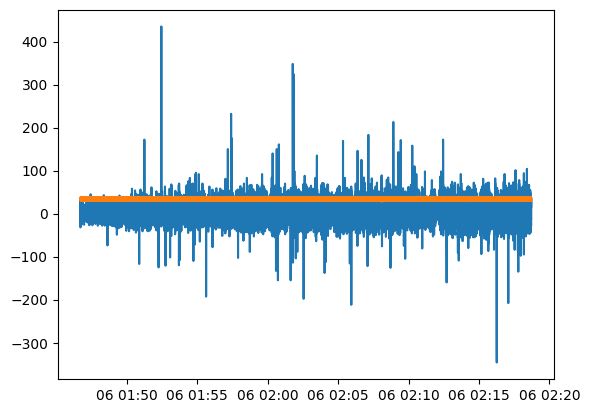

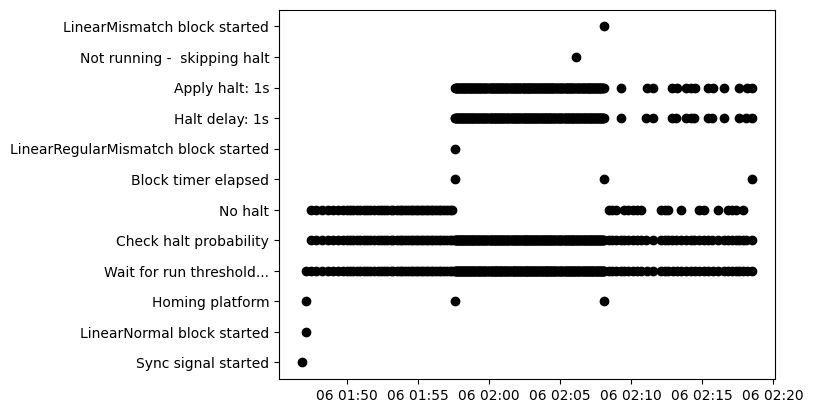

In [21]:
print(experiment_events)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0Y'])
plt.plot(analog_input['AnalogInput'])

plt.figure()
plt.scatter(experiment_events.index, experiment_events["Event"], c='k')

In [17]:
# read onix streams
# stream assigns a harp timestamp to each analog block
analog_frame_count = utils.load(framecount_reader, root_folder)
print(analog_frame_count)

# directly read an onix analog data / clock bin file
analog_data = utils.read_onix_analog_data(root_folder, "OnixAnalogData", np.int16)
analog_clock = utils.read_onix_analog_clock(root_folder, "OnixAnalogClock", np.uint64)

# confirm relationship between data, clock and frame count
print(analog_data.shape[0], analog_clock.shape[0], analog_frame_count["Index"][-1])

                              Index        Seconds
Time                                              
1904-01-06 01:46:41.460256        0  438401.460256
1904-01-06 01:46:41.470240        1  438401.470240
1904-01-06 01:46:41.470240        2  438401.470240
1904-01-06 01:46:41.470240        3  438401.470240
1904-01-06 01:46:41.470240        4  438401.470240
...                             ...            ...
1904-01-06 02:18:41.990240  1917257  440321.990240
1904-01-06 02:18:41.990240  1917258  440321.990240
1904-01-06 02:18:41.990240  1917259  440321.990240
1904-01-06 02:18:41.990240  1917260  440321.990240
1904-01-06 02:18:41.990240  1917261  440321.990240

[1917262 rows x 2 columns]
191726100 191726100 1917261


C:\Users\neurogears\AppData\Local\Temp\ipykernel_31240\2831765614.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(analog_data.shape[0], analog_clock.shape[0], analog_frame_count["Index"][-1])


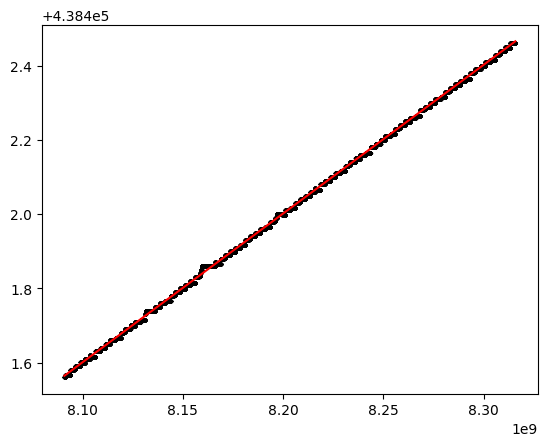

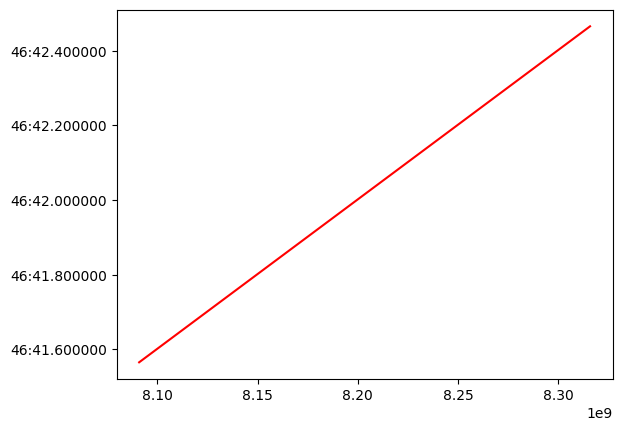

In [19]:
# find time mapping/warping between onix and harp clock
upsample = np.array(analog_frame_count["Seconds"]).repeat(100, axis=0)[0:-100]

# define conversion functions between timestamps
m, b = np.polyfit(analog_clock, upsample, 1)
onix_to_harp_seconds = lambda x: x*m + b
onix_to_harp_timestamp = lambda x: api.aeon(onix_to_harp_seconds(x)) 

window = range(10000, 100000)
plt.figure()
plt.scatter(analog_clock[window], upsample[window], c='k', s=2)
plt.plot(analog_clock[window], onix_to_harp_seconds(analog_clock[window]), c='r')

plt.figure()
plt.plot(analog_clock[window], onix_to_harp_timestamp(analog_clock[window]), c='r')

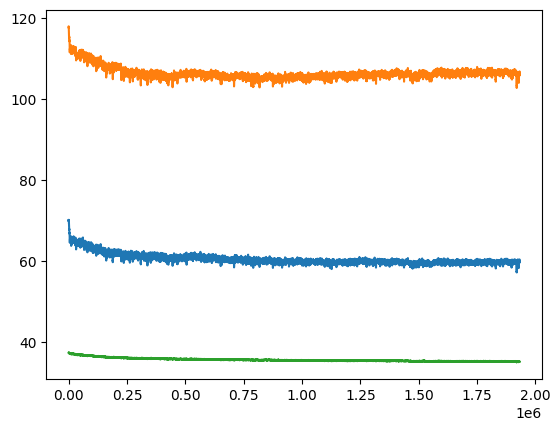

In [12]:
# read photometry stream
photometry = utils.load_photometry(photometry_reader, root_folder_photometry)

plt.figure()
plt.plot(photometry[0]["CH1-410"])
plt.plot(photometry[0]["CH1-470"])
plt.plot(photometry[0]["CH1-560"])

In [ ]:
# photometry sync example

In [ ]:
# example, see harp data, experiment events, video frames and onix data for a given window, synchronised.